[STATUS] Started extracting haralick textures...
Processing Image - 1 in jahe
Processing Image - 2 in jahe
Processing Image - 3 in jahe
Processing Image - 1 in kunyit
Processing Image - 2 in kunyit
Processing Image - 3 in kunyit
Processing Image - 1 in lengkuas
Processing Image - 2 in lengkuas
Processing Image - 3 in lengkuas
Processing Image - 1 in sirih
Processing Image - 2 in sirih
Processing Image - 3 in sirih
Training features: (12, 13)
Training labels: (12,)
[STATUS] Creating the classifier...
[STATUS] Fitting data/label to model...

[STATUS] Starting testing phase...

File: test_1.jpg | Predicted Label: jahe
File: test_4.jpg | Predicted Label: jahe
File: test_5.jpg | Predicted Label: sirih


c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


File: test_6.jpg | Predicted Label: lengkuas


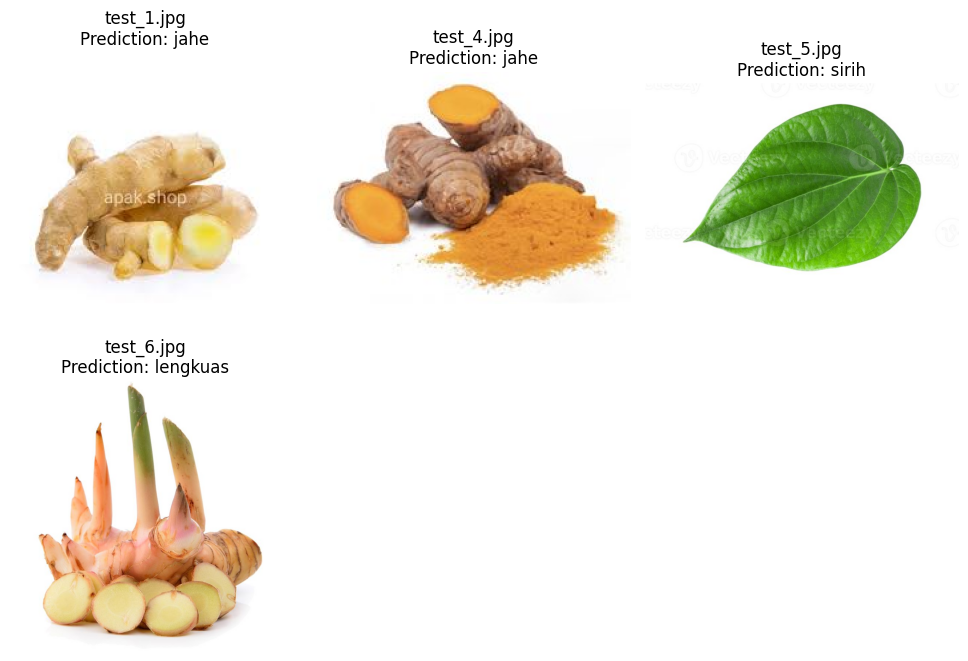

In [2]:
import cv2
import numpy as np
import os
import glob
import mahotas as mt
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt

# Function to extract haralick textures from an image
def extract_features(image):
    # Calculate haralick texture features for 4 types of adjacency
    textures = mt.features.haralick(image)
    
    # Take the mean of it and return it
    ht_mean = textures.mean(axis=0)
    return ht_mean

# Load the training dataset
train_path = "dataset/train"
train_names = os.listdir(train_path)

# Empty list to hold feature vectors and train labels
train_features = []
train_labels = []

# Loop over the training dataset
print("[STATUS] Started extracting haralick textures...")
for train_name in train_names:
    cur_path = os.path.join(train_path, train_name)
    cur_label = train_name
    i = 1

    for file in glob.glob(os.path.join(cur_path, "*.jpg")):
        print(f"Processing Image - {i} in {cur_label}")

        # Read the training image
        image = cv2.imread(file)

        # Convert the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Extract haralick texture from the image
        features = extract_features(gray)

        # Append the feature vector and label
        train_features.append(features)
        train_labels.append(cur_label)

        # Show loop update
        i += 1

# Display training data details
print(f"Training features: {np.array(train_features).shape}")
print(f"Training labels: {np.array(train_labels).shape}")

# Create the classifier
print("[STATUS] Creating the classifier...")
clf_svm = LinearSVC(random_state=9, max_iter=10000)  # Adjust max_iter to avoid warnings

# Fit the training data and labels
print("[STATUS] Fitting data/label to model...")
clf_svm.fit(train_features, train_labels)

# Test the model
test_path = "dataset/test"
print("\n[STATUS] Starting testing phase...\n")

# Prepare to display results
plt.figure(figsize=(10, 10))

for idx, file in enumerate(glob.glob(os.path.join(test_path, "*.jpg"))):
    # Read the input image
    image = cv2.imread(file)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Extract haralick texture from the image
    features = extract_features(gray)

    # Evaluate the model and predict label
    prediction = clf_svm.predict(features.reshape(1, -1))[0]

    # Display the prediction and image
    file_name = os.path.basename(file)
    print(f"File: {file_name} | Predicted Label: {prediction}")
    
    # Show the image and prediction in matplotlib
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.subplot(3, 3, idx + 1)  # Create a grid of 3x3 (adjust based on the number of test images)
    plt.imshow(rgb_image)
    plt.title(f"{file_name}\nPrediction: {prediction}")
    plt.axis('off')

# Show all results
plt.tight_layout()
plt.show()


[STATUS] Started extracting features (Haralick + Color)...
Processing Image - 1 in jahe
Processing Image - 2 in jahe
Processing Image - 3 in jahe
Processing Image - 1 in kunyit
Processing Image - 2 in kunyit
Processing Image - 3 in kunyit
Processing Image - 1 in lengkuas
Processing Image - 2 in lengkuas
Processing Image - 3 in lengkuas
Processing Image - 1 in sirih
Processing Image - 2 in sirih
Processing Image - 3 in sirih
Training features: (12, 397)
Training labels: (12,)
[STATUS] Creating the classifier...
[STATUS] Fitting data/label to model...


c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



[STATUS] Starting testing phase...

File: test_1.jpg | Predicted Label: jahe
File: test_4.jpg | Predicted Label: kunyit
File: test_5.jpg | Predicted Label: kunyit
File: test_6.jpg | Predicted Label: lengkuas


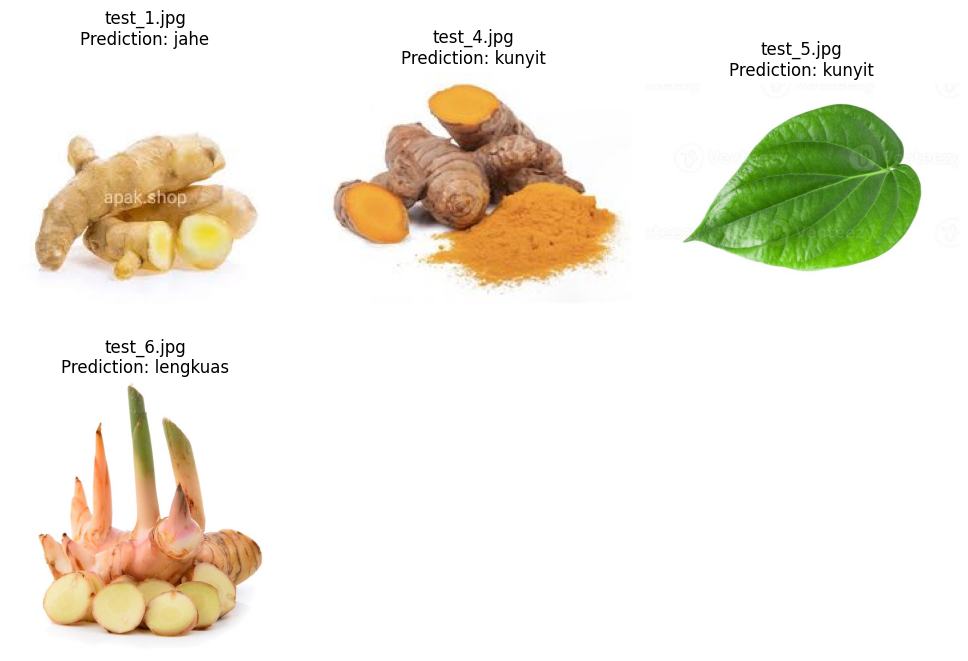

In [1]:
import cv2
import numpy as np
import os
import glob
import mahotas as mt
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt

# Function to extract haralick textures from an image
def extract_haralick_features(image):
    # Calculate haralick texture features for 4 types of adjacency
    textures = mt.features.haralick(image)
    
    # Take the mean of it and return it
    ht_mean = textures.mean(axis=0)
    return ht_mean

# Function to extract color histogram features (for Lab channels)
def extract_color_histogram(image, bins=128):
    # Convert image to Lab
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    
    hist_features = []
    for channel in cv2.split(lab_image):  # Extract histogram for each Lab channel
        hist = cv2.calcHist([channel], [0], None, [bins], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()  # Normalize and flatten the histogram
        hist_features.extend(hist)  # Combine histograms from L, a, b
    return hist_features

# Function to combine Haralick features and color histogram features, prioritizing color features
def extract_combined_features(image, texture_weight=0.2, color_weight=0.8):
    # Extract Haralick texture features from grayscale image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick_features = extract_haralick_features(gray)
    
    # Extract color histogram features from the original image in Lab space
    color_features = extract_color_histogram(image)
    
    # Convert both features to numpy arrays for multiplication
    haralick_features = np.array(haralick_features)
    color_features = np.array(color_features)
    
    # Combine both features into a single feature vector, prioritizing color features
    combined_features = np.hstack([haralick_features * texture_weight, color_features * color_weight])
    return combined_features

# Load the training dataset
train_path = "dataset/train"
train_names = os.listdir(train_path)

# Empty list to hold feature vectors and train labels
train_features = []
train_labels = []

# Loop over the training dataset
print("[STATUS] Started extracting features (Haralick + Color)...")
for train_name in train_names:
    cur_path = os.path.join(train_path, train_name)
    cur_label = train_name
    i = 1

    for file in glob.glob(os.path.join(cur_path, "*.jpg")):
        print(f"Processing Image - {i} in {cur_label}")

        # Read the training image
        image = cv2.imread(file)

        # Extract combined features (Haralick + Color Histogram)
        features = extract_combined_features(image)

        # Append the feature vector and label
        train_features.append(features)
        train_labels.append(cur_label)

        # Show loop update
        i += 1

# Display training data details
print(f"Training features: {np.array(train_features).shape}")
print(f"Training labels: {np.array(train_labels).shape}")

# Create the classifier
print("[STATUS] Creating the classifier...")
clf_svm = LinearSVC(random_state=9, max_iter=10000)  # Adjust max_iter to avoid warnings

# Fit the training data and labels
print("[STATUS] Fitting data/label to model...")
clf_svm.fit(train_features, train_labels)

# Test the model
test_path = "dataset/test"
print("\n[STATUS] Starting testing phase...\n")

# Prepare to display results
plt.figure(figsize=(10, 10))

for idx, file in enumerate(glob.glob(os.path.join(test_path, "*.jpg"))):
    # Read the input image
    image = cv2.imread(file)

    # Extract combined features (Haralick + Color Histogram)
    features = extract_combined_features(image)

    # Evaluate the model and predict label
    prediction = clf_svm.predict(features.reshape(1, -1))[0]

    # Display the prediction and image
    file_name = os.path.basename(file)
    print(f"File: {file_name} | Predicted Label: {prediction}")
    
    # Show the image and prediction in matplotlib
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.subplot(3, 3, idx + 1)  # Create a grid of 3x3 (adjust based on the number of test images)
    plt.imshow(rgb_image)
    plt.title(f"{file_name}\nPrediction: {prediction}")
    plt.axis('off')

# Show all results
plt.tight_layout()
plt.show()


[STATUS] Started extracting features (Haralick + Color)...
Processing Image - 1 in jahe
Processing Image - 2 in jahe
Processing Image - 3 in jahe
Processing Image - 1 in kunyit
Processing Image - 2 in kunyit
Processing Image - 3 in kunyit
Processing Image - 1 in lengkuas
Processing Image - 2 in lengkuas
Processing Image - 3 in lengkuas
Processing Image - 1 in sirih
Processing Image - 2 in sirih
Processing Image - 3 in sirih
Training features: (12, 781)
Training labels: (12,)
[STATUS] Creating the classifier...
[STATUS] Fitting data/label to model...

[STATUS] Starting testing phase...



c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


File: test_1.jpg | Predicted Label: jahe
File: test_4.jpg | Predicted Label: kunyit
File: test_5.jpg | Predicted Label: kunyit
File: test_6.jpg | Predicted Label: lengkuas


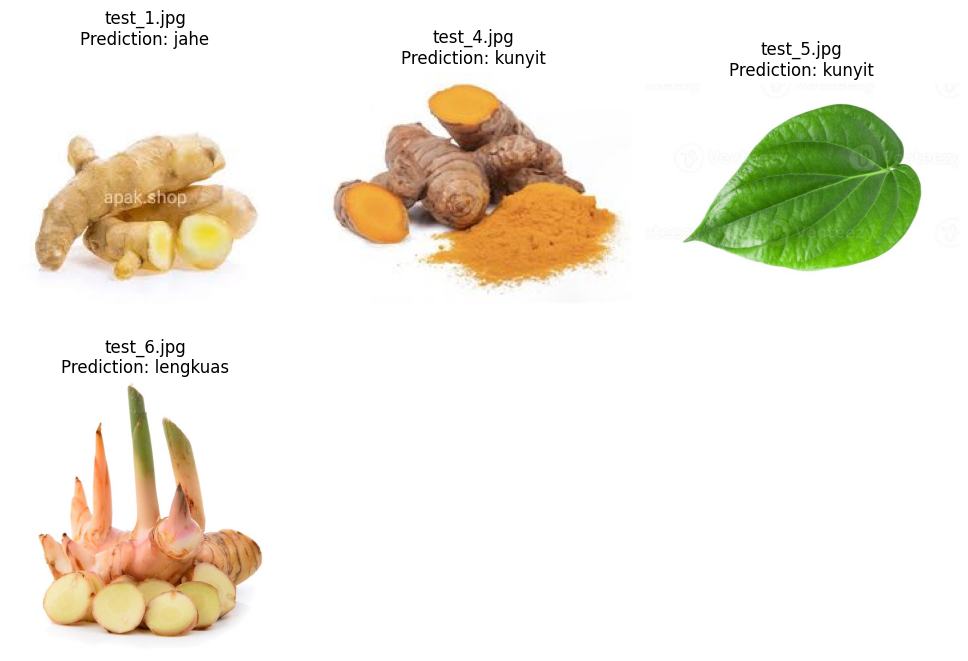

In [6]:
import cv2
import numpy as np
import os
import glob
import mahotas as mt
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt

# Function to convert RGB to XYZ
def rgb_to_xyz(rgb):
    rgb = np.array(rgb) / 255.0
    rgb = rgb * 100
    xyz_matrix = np.array([[0.412452, 0.357580, 0.180423],
                           [0.212671, 0.715160, 0.072169],
                           [0.019334, 0.119193, 0.950227]])

    xyz = np.dot(xyz_matrix, rgb)
    return xyz

# Function to convert XYZ to Lab
def xyz_to_lab(xyz):
    white_ref = np.array([95.047, 100.000, 108.883])

    xyz = xyz / white_ref

    mask = xyz > 0.008856
    xyz[mask] = np.cbrt(xyz[mask])
    xyz[~mask] = (7.787 * xyz[~mask]) + (16 / 116)

    L = (116 * xyz[1]) - 16
    a = 500 * (xyz[0] - xyz[1])
    b = 200 * (xyz[1] - xyz[2])

    return np.array([L, a, b])

# Function to convert RGB to Lab
def rgb_to_lab(rgb):
    xyz = rgb_to_xyz(rgb)
    lab = xyz_to_lab(xyz)
    return lab

# Function to convert an image from RGB to Lab
def image_rgb_to_lab(image):
    h, w, _ = image.shape
    lab_image = np.zeros((h, w, 3), dtype=np.float32)
    for i in range(h):
        for j in range(w):
            rgb_pixel = image[i, j]
            lab_pixel = rgb_to_lab(rgb_pixel)
            lab_image[i, j] = lab_pixel

    return lab_image

# Function to extract haralick textures from an image
def extract_haralick_features(image):
    textures = mt.features.haralick(image)
    ht_mean = textures.mean(axis=0)
    return ht_mean

# Function to extract color histogram features (for Lab channels)
def extract_color_histogram(image, bins=256):
    # Convert image to Lab manually
    lab_image = image_rgb_to_lab(image)
    
    hist_features = []
    for channel in range(3):  # L, a, and b channels
        hist = cv2.calcHist([lab_image], [channel], None, [bins], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()  # Normalize and flatten the histogram
        hist_features.extend(hist)  # Combine histograms from L, a, b
    return hist_features

# Function to combine Haralick features and color histogram features, prioritizing color features
def extract_combined_features(image, texture_weight=0.2, color_weight=0.8):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick_features = extract_haralick_features(gray)
    color_features = extract_color_histogram(image)
    
    haralick_features = np.array(haralick_features)
    color_features = np.array(color_features)
    
    combined_features = np.hstack([haralick_features * texture_weight, color_features * color_weight])
    return combined_features

# Load the training dataset
train_path = "dataset/train"
train_names = os.listdir(train_path)

train_features = []
train_labels = []

print("[STATUS] Started extracting features (Haralick + Color)...")
for train_name in train_names:
    cur_path = os.path.join(train_path, train_name)
    cur_label = train_name
    i = 1

    for file in glob.glob(os.path.join(cur_path, "*.jpg")):
        print(f"Processing Image - {i} in {cur_label}")

        # Read the training image
        image = cv2.imread(file)

        # Extract combined features (Haralick + Color Histogram)
        features = extract_combined_features(image)

        # Append the feature vector and label
        train_features.append(features)
        train_labels.append(cur_label)

        i += 1

print(f"Training features: {np.array(train_features).shape}")
print(f"Training labels: {np.array(train_labels).shape}")

# Create the classifier
print("[STATUS] Creating the classifier...")
clf_svm = LinearSVC(random_state=9, max_iter=10000)

print("[STATUS] Fitting data/label to model...")
clf_svm.fit(train_features, train_labels)

# Test the model
test_path = "dataset/test"
print("\n[STATUS] Starting testing phase...\n")

# Prepare to display results
plt.figure(figsize=(10, 10))

for idx, file in enumerate(glob.glob(os.path.join(test_path, "*.jpg"))):
    image = cv2.imread(file)
    features = extract_combined_features(image)

    prediction = clf_svm.predict(features.reshape(1, -1))[0]

    file_name = os.path.basename(file)
    print(f"File: {file_name} | Predicted Label: {prediction}")
    
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 3, idx + 1)
    plt.imshow(rgb_image)
    plt.title(f"{file_name}\nPrediction: {prediction}")
    plt.axis('off')

plt.tight_layout()
plt.show()
